<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/jonasnylund/Lab-2/jonasnylund_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Jonas Nylund**

# **Abstract**

We simulate flow around a cylinder and calculate the coefficient of drag and lift, as well as the strouhal number, for different flow regimes and mesh accuracies.
The results are of mixed expectations, as the drag and lift coefficients are unexpectedly large

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Jonas Nylund (jonasnyl@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
import scipy.signal 

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

In [0]:
# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      

def defDomain(plotting=True, resolution=32, ref=0, spec=False):
  global left, right, lower, upper, mesh, boundaries
  global L,H, xc,yc,rc

  if spec:
    # Define rectangular domain 
    L = 2.2
    H = 0.41

    # Define circle
    xc = 0.2
    yc = 0.2
    rc = 0.05
  else:
    # Define rectangular domain 
    L = 4
    H = 2

    # Define circle
    xc = 1.0
    yc = 0.5*H
    rc = 0.2

  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Generate mesh (examples with and without a hole in the mesh) 
  #resolution = 32
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)
  no_levels = ref
  # Local mesh refinement (specified by a cell marker)
  
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(xc, yc)) < 3*rc:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

  if plotting:
    plt.figure()
    plot(mesh)
    plt.show()

**Define finite element approximation spaces**

In [0]:
# Generate finite element spaces (for velocity and pressure)

def defApproxSpace():
  global V,Q,u,p,v,q
  
  V = VectorFunctionSpace(mesh, "Lagrange", 1)
  Q = FunctionSpace(mesh, "Lagrange", 1)

  # Define trial and test functions 
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)

**Define boundary conditions**

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))


def defBC(spec = False):
  global dbc_lower, dbc_upper, dbc_left, dbc_right, dbc_objects, uin, bcu_in0, bcu_in1
  global bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1, pin, pout, bcp1, bcu, bcp
  global ds

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  # Examples of time dependent and stationary inflow conditions
  if(spec):
    uin = Expression('6.0*x[1]*(H-x[1])/(H*H)', H=H, element = V.sub(0).ufl_element())
  else:
    uin = 1.0

  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  #bcp0 = DirichletBC(Q, pin, dbc_left) 
  bcp1 = DirichletBC(Q, pout, dbc_right)

  if(spec):
    bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  else:
    bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
  bcp = [bcp1]

  # Define measure for boundary integration  
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [0]:
# Set viscosity
# nu = 4.0e-3
# Re = 2*rc/nu
# print("Reynolds number Re:", Re)

def defFlowParams(re):
  global Re, nu
  Re = re
  nu = 2*rc/Re
  print("Reynolds number:", Re, "Viscosity:", nu)

**Define method parameters**

In [0]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  

def defMethParams():
  global u0, u1, p0, p1, num_nnlin_iter, prec, dt
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Set parameters for nonlinear and lienar solvers 
  num_nnlin_iter = 5 
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

  # Time step length 
  dt = 0.5*mesh.hmin()

**Define variational problem**

In [0]:
# Define variational problem


def defVariProb():
  global h, mesh, u_mag, d1, d2, um, um1, Fu, au, Lu, Fp, ap, Lp
  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = h*u_mag

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0)

  # Momentum variational equation on residual form
  Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
      + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
  ap = lhs(Fp)
  Lp = rhs(Fp)

**Compute force on boundary**

In [0]:
# Define the direction of the force to be computed 

def forceExp(plotting = False):
  global psiX_expression, psiY_expression, psi_x, psi_y, Force_x, Force_y, D, normalization
  #phi_x = 0.0
  #phi_y = 1.0

  psiX_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? 1.0 : 0.0","0.0"), xc=xc, yc=yc, rc=rc, element = V.ufl_element())
  psiY_expression = Expression(("0.0","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? 1.0 : 0.0"), xc=xc, yc=yc, rc=rc, element = V.ufl_element())
  
  psi_x = interpolate(psiX_expression, V)
  psi_y = interpolate(psiY_expression, V)

  Force_x = inner((u1 - u0)/dt + grad(um1)*um1, psi_x)*dx - p1*div(psi_x)*dx + nu*inner(grad(um1), grad(psi_x))*dx
  Force_y = inner((u1 - u0)/dt + grad(um1)*um1, psi_y)*dx - p1*div(psi_y)*dx + nu*inner(grad(um1), grad(psi_y))*dx

  if plotting:
    plt.figure()
    plot(psi_x, title="weight function psi_x")
    plot(psi_y, title="weight function psi_y")

  # Force normalization
  D = 2*rc
  normalization = -2.0/D

**Set plotting variables and open export files**

In [0]:
# Open files to export solution to Paraview

def defplot():
  global file_u, file_p, plot_time, plot_freq, force_array, lift_array, time, start_sample_time
  file_u = File("results-NS/u.pvd")
  file_p = File("results-NS/p.pvd")

  # Set plot frequency
  plot_time = 0
  plot_freq = 10

  # Force computation data 
  force_array = np.array(0.0)
  force_array = np.delete(force_array, 0)
  lift_array = np.array(0.0)
  lift_array = np.delete(lift_array, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0

**Time stepping algorithm**

In [0]:
def plotResult(vel=True, press=True, force=True):

  if vel:
    plt.figure()
    plot(u1, title="Velocity")
    plt.show()

  if press:
    plt.figure()
    plot(p1, title="Pressure")
    plt.show()

  if force:
    plt.figure()
    plt.title("Force")
    plt.plot(time, force_array, label="Drag force")
    plt.plot(time, lift_array, label="Lift force")
    plt.legend()
    plt.show()

def runSimulation(plotting=True, calcForces=False, T=30):
  global plot_time, t, dt, num_nnlin_iter, Fx, Fy, force_array, lift_array, time, bc, Ap, bp

  !rm results-NS/*

  # Time stepping 
  t = dt
  while t < T + DOLFIN_EPS:

      #s = 'Time t = ' + repr(t) 
      #print(s)

      pin.t = t
      #uin.t = t

      # Solve non-linear problem 
      k = 0
      while k < num_nnlin_iter: 
          
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        if(calcForces):
          Fx = assemble(Force_x)
          Fy = assemble(Force_y)
          if (t > start_sample_time):
            force_array = np.append(force_array, normalization*Fx)
            lift_array = np.append(lift_array, normalization*Fy);
            time = np.append(time, t)

        k += 1

      if t > plot_time: 

        s = 'Time t = ' + repr(t) 
        print(s) 

        plot_time += T/plot_freq

        if plotting:
      
          # Save solution to file
          file_u << u1
          file_p << p1

          # Plot solution
          plotResult(force=False)

      # Update time step
      u0.assign(u1)
      t += dt


  #!tar -czvf results-NS.tar.gz results-NS
  #files.download('results-NS.tar.gz')

In [0]:
## For the strouhal number we need to calculate the 
## frequency of oscillation. We can use fft for this.
def calcStrouhal(w=True):

  peaks = scipy.signal.find_peaks(lift_array, height=0.1, distance=10)[0]
  peaks = peaks[len(peaks)//3:]

  freq = 0
  Sr = 0
  if(len(peaks)>1):
    freq = (len(peaks)-1)/(time[peaks[-1]]-time[peaks[0]]);
  Sr = freq*2*rc;

  #fft = np.fft.fft(lift_array);
  #freq = np.fft.fftfreq(time.shape[-1])/((time[-1]-time[0])/len(time))
  ## Get the frequency with highest amplitude (will be the only one)
  #Sr = abs(freq[np.argmax(abs(fft.real))])*2*rc/uin

  if(w):
    #print("Oscillation frequency:", round(abs(freq[np.argmax(abs(fft.real))]), 4),"Hz")
    print("Oscillation frequency:", round(freq, 4),"Hz")
    print("Strouhal number:", round(Sr,3))

  return Sr

def calcCdCf(array):
  res = dict();
  ## Calculate rms and some other averages for later use.
  res["rms"] = np.sqrt(np.power(array[len(array)//3:], 2).mean())
  res["rmse"] = np.sqrt(np.power(array[len(array)//3:] - res["rms"], 2).mean())
  res["max"] = np.max(np.abs(array[len(array)//3:]))
  res["avg"] = np.mean(array[len(array)//3:])
  res["std"] = np.std(array[len(array)//3:])

  return res

#**Reynolds number**

We run the simulation for different Reynolds numbers in the range [1 10000]. We change the reynolds number by setting the viscosity $\nu = 2r_c/Re$. 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Reynolds number: 1 Viscosity: 0.4
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.0170500855234

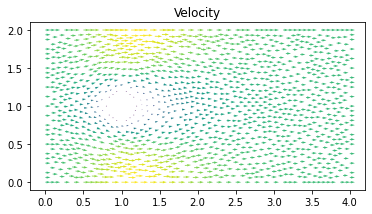

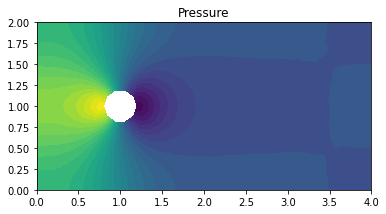

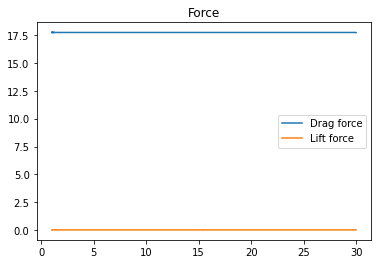

Oscillation frequency: 0 Hz
Strouhal number: 0.0
Reynolds number: 10 Viscosity: 0.04
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.017050085523426
Time t = 27.006860698085248


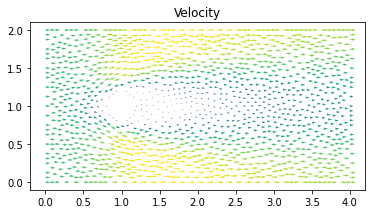

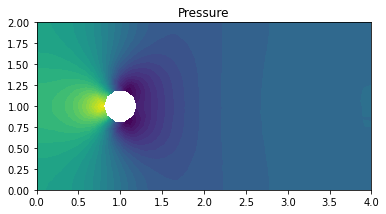

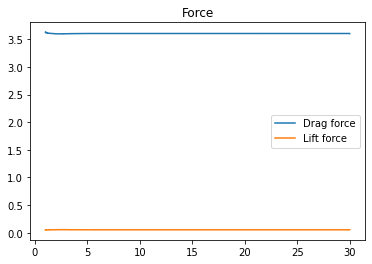

Oscillation frequency: 0 Hz
Strouhal number: 0.0
Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.017050085523426
Time t = 27.006860698085248


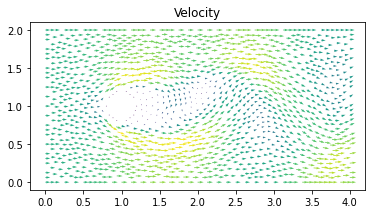

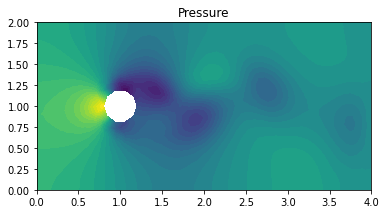

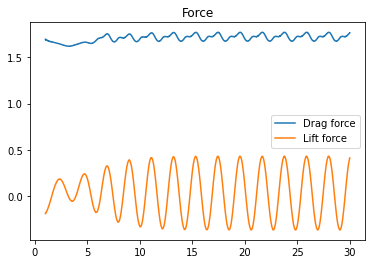

Oscillation frequency: 0.4737 Hz
Strouhal number: 0.189
Reynolds number: 1000 Viscosity: 0.0004
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.017050085523426
Time t = 27.006860698085248


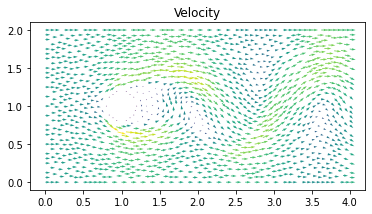

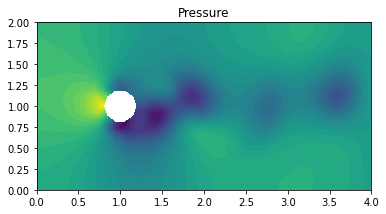

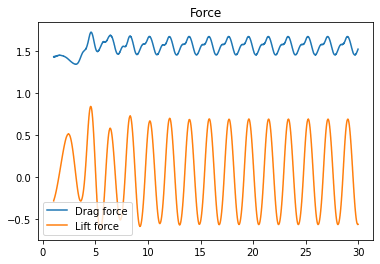

Oscillation frequency: 0.5309 Hz
Strouhal number: 0.212
Reynolds number: 10000 Viscosity: 4e-05
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.017050085523426
Time t = 27.006860698085248


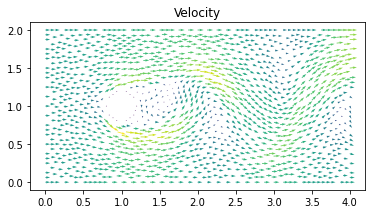

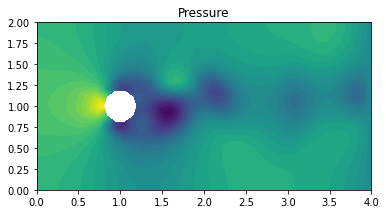

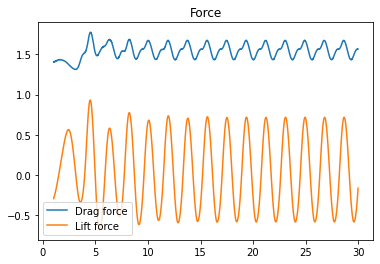

Oscillation frequency: 0.5371 Hz
Strouhal number: 0.215


In [14]:
re = [10**i for i in range(5)]
sr = [];
cd = [];
cf = [];

for r in re:
  # Redefine everything since things change during simulation. 
  # Something with arraysizes crashes otherwise
  print("="*40)
  defDomain(plotting=False) ## Dont plot the mesh every time
  defApproxSpace()
  defBC()
  defFlowParams(r)  # Set reynolds number to r
  defMethParams()
  defVariProb()
  forceExp()
  defplot()
  runSimulation(plotting=False, calcForces=True)
  plotResult(vel=True, press=True, force=True)

  s = calcStrouhal(w=True)
  cd.append(calcCdCf(force_array))
  cf.append(calcCdCf(lift_array))
  sr.append(s);

We see that for regimes where we have high viscosity, that is, viscous forces are dominant, we have steady flow and no vortex shedding. When viscosity goes down (and Reynolds number goes up), we see that the flow separates from the cylinder backside and becomes unsteady, shedding vortices in the wake.

#**Strouhal number**

The Strouhal number (Sr) is calculated as $fD/\overline U_{in}$, where $\overline U_{in}$ is the free stream velocity and $f$ the frequency of vortex shedding.

We see that for low Reynolds numbers (< 100) the flow is steady and we have $Sr << 1$ since $f << 1$. For higher Reyolds numbers we have vortices in the wake, and the $Sr$ is about 0.2 as expected. 

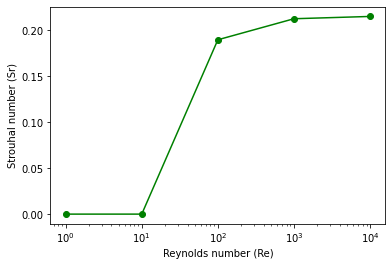

In [15]:
plt.figure()
plt.semilogx(re, sr, "go-")
plt.xlabel("Reynolds number (Re)")
plt.ylabel("Strouhal number (Sr)")
plt.show()

#**Drag and lift coefficients**

The coefficients of drag ($C_d$) and lift ($C_l$) are defined as $C_i = \frac{2F_i}{\rho u^2 A}$ for $i=d,l$ respectively. 
When the flow is steady, the force on the cylinder is purely in the flowwise direction and $C_l=0$ as expected. In this regime the $C_d$ is very high, as a result of the very high viscosity of the fluid. As viscosity goes down (Reynolds number goes up), the coefficient of drag goes down, however it remains higher than expected and is about twice as high as expected for a cylinder.

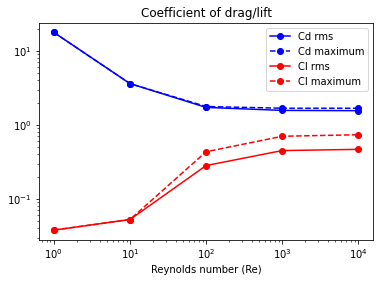

In [17]:
def plotCdCf(array, Re, label, color):
  _rms = [];
  _avg = [];
  _max = [];

  for c in array:
    _rms.append(c["rms"])
    _max.append(c["max"])

  plt.plot(Re, _rms, color+"o-", label=label + " rms");
  plt.plot(Re, _max, color+"o--", label=label + " maximum");

plotCdCf(cd, re, "Cd", "b")
plotCdCf(cf, re, "Cl", "r")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reynolds number (Re)")
plt.title("Coefficient of drag/lift")
plt.legend()
plt.show()

#**Mesh resolution**

For lower resolutions of the mesh, we don't get the same flow pattern in the stream. For very coarse meshes, the vortex shedding is not observed, and the resulting value for the Strouhal number and $C_d, C_l$ are widely different from those of finer meshes.

It should be noted however that changing the mesh coarsness also changes the timestep dt, which also affects the simulation accuracy.

Mesh size: 8


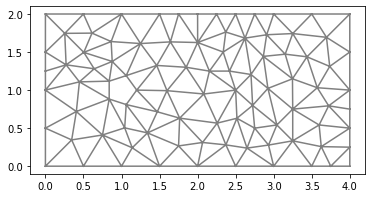

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.13091486480653436
Time t = 3.011041890550292
Time t = 6.022083781100587
Time t = 9.033125671650883
Time t = 12.044167562201178
Time t = 15.055209452751473
Time t = 18.06625134330177
Time t = 21.077293233852064
Time t = 24.08833512440236
Time t = 27.099377014952655


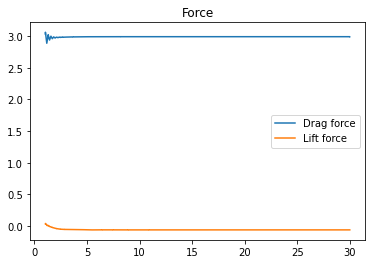

Oscillation frequency: 0 Hz
Strouhal number: 0.0
Mesh size: 12


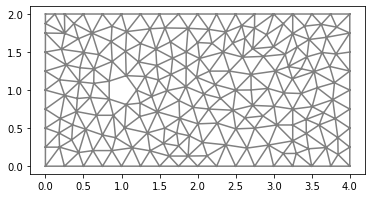

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.08731667637266713
Time t = 3.05608367304335
Time t = 6.024850669714023
Time t = 9.080934342757368
Time t = 12.049701339428067
Time t = 15.018468336098765
Time t = 18.07455200914209
Time t = 21.043319005812727
Time t = 24.012086002483365
Time t = 27.06816967552667


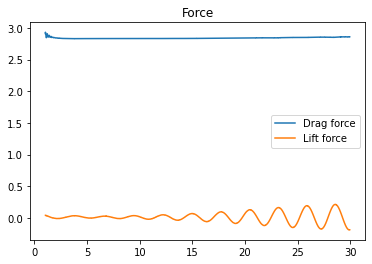

Oscillation frequency: 0.3776 Hz
Strouhal number: 0.151
Mesh size: 16


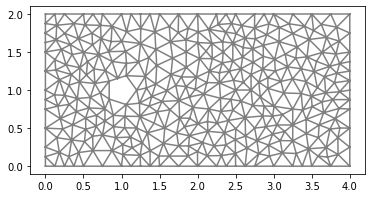

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.06628038350651762
Time t = 3.0488976412998086
Time t = 6.031514899093112
Time t = 9.01413215688642
Time t = 12.063029798186248
Time t = 15.045647055979558
Time t = 18.028264313772812
Time t = 21.010881571566042
Time t = 24.059779212865788
Time t = 27.042396470659018


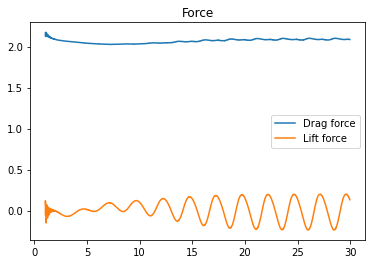

Oscillation frequency: 0.4041 Hz
Strouhal number: 0.162
Mesh size: 24


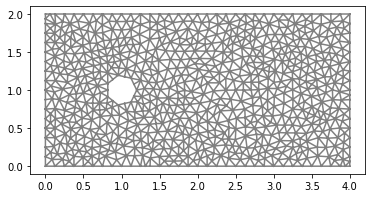

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.04338837391175582
Time t = 3.037186173822909
Time t = 6.030983973734072
Time t = 9.024781773645214
Time t = 12.018579573556316
Time t = 15.012377373467418
Time t = 18.0061751733786
Time t = 21.043361347201582
Time t = 24.037159147112806
Time t = 27.03095694702403


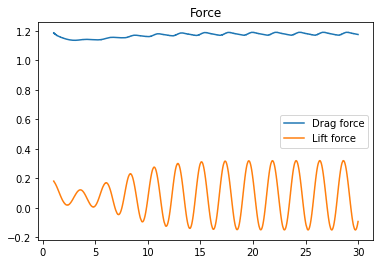

Oscillation frequency: 0.4444 Hz
Strouhal number: 0.178
Mesh size: 32


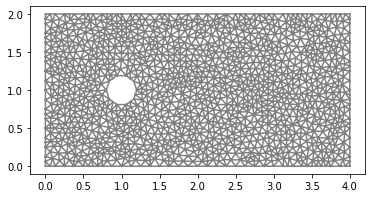

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.017050085523426
Time t = 27.006860698085248


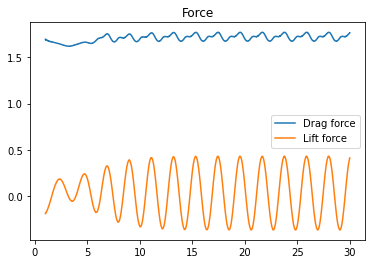

Oscillation frequency: 0.4737 Hz
Strouhal number: 0.189


In [18]:
mesh_s = [8,12,16,24,32]
sr = [];
cd = [];
cf = [];

for size in mesh_s:
  # Redefine everything since things change during simulation. 
  # Something with arraysizes crashes otherwise
  print("="*40)
  print("Mesh size:", size)
  defDomain(plotting=True, resolution=size) # Mesh coarsness changes every iteration
  defApproxSpace()
  defBC()
  defFlowParams(100)  # Set reynolds number to 100
  defMethParams()
  defVariProb()
  forceExp()
  defplot()
  runSimulation(plotting=False, calcForces=True)
  plotResult(vel=False, press=False, force=True)

  s = calcStrouhal(w=True)
  cd.append(calcCdCf(force_array))
  cf.append(calcCdCf(lift_array))
  sr.append(s);

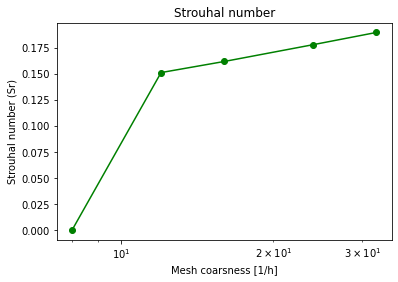

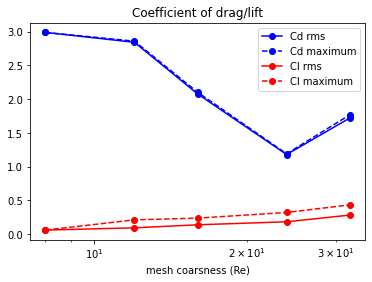

In [19]:
plt.figure()
plt.title("Strouhal number")
plt.semilogx(mesh_s, sr, "go-")
plt.xlabel("Mesh coarsness [1/h]")
plt.ylabel("Strouhal number (Sr)")
plt.show()

plt.figure()
plotCdCf(cd, mesh_s, "Cd", "b")
plotCdCf(cf, mesh_s, "Cl", "r")

plt.xscale("log")
plt.xlabel("mesh coarsness (Re)")
plt.title("Coefficient of drag/lift")
plt.legend()
plt.show()

**Mesh refinedment**

Intersetingly, refining the mesh in an area around the cylinder gives a very different result, where the Strouhal number is about the same, the Coefficient of lift and drag are very different, and the values for a coarser mesh that has been refined in an area differ more than just a finer mesh. I have no good explanation for this.

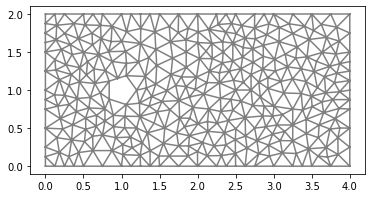

Reynolds number: 100 Viscosity: 0.004
Time t = 0.06628038350651762
Time t = 3.0488976412998086
Time t = 6.031514899093112
Time t = 9.01413215688642
Time t = 12.063029798186248
Time t = 15.045647055979558
Time t = 18.028264313772812
Time t = 21.010881571566042
Time t = 24.059779212865788
Time t = 27.042396470659018


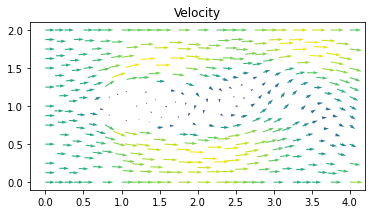

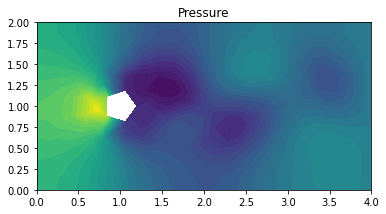

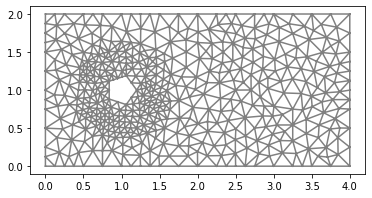

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.03568635407996775
Time t = 3.033340096797255
Time t = 6.030993839514565
Time t = 9.028647582231862
Time t = 12.02630132494911
Time t = 15.023955067666357
Time t = 18.021608810383604
Time t = 21.01926255310085
Time t = 24.0169162958181
Time t = 27.014570038535346


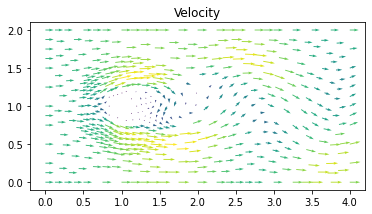

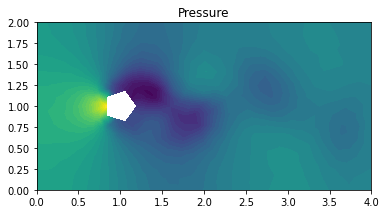

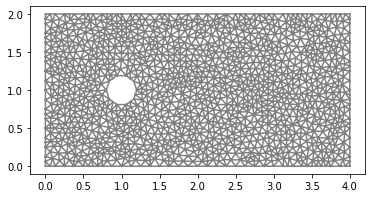

Reynolds number: 100 Viscosity: 0.004
rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.03285506167650246
Time t = 3.022665674238231
Time t = 6.012476286799972
Time t = 9.002286899361685
Time t = 12.024952573599847
Time t = 15.014763186161508
Time t = 18.00457379872328
Time t = 21.027239472961604
Time t = 24.017050085523426
Time t = 27.006860698085248


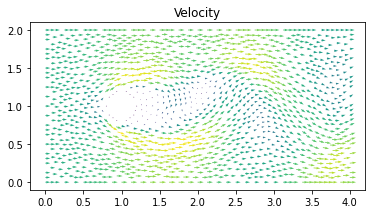

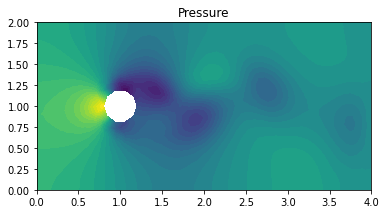

In [23]:
print("="*40)
defDomain(plotting=True, resolution=16, ref=0)
defApproxSpace()
defBC()
defFlowParams(100)
defMethParams()
defVariProb()
forceExp()
defplot()
runSimulation(plotting=False, calcForces=True)
plotResult(vel=True, press=True, force=False)

_sr1 = calcStrouhal(w=False);
_cd1 = calcCdCf(force_array)
_cl1 = calcCdCf(lift_array)

print("="*40)
defDomain(plotting=True, resolution=16, ref=1)
defApproxSpace()
defBC()
defFlowParams(100)
defMethParams()
defVariProb()
forceExp()
defplot()
runSimulation(plotting=False, calcForces=True)
plotResult(vel=True, press=True, force=False)

_sr2 = calcStrouhal(w=False)
_cd2 = calcCdCf(force_array)
_cl2 = calcCdCf(lift_array)

print("="*40)
defDomain(plotting=True, resolution=32, ref=0)
defApproxSpace()
defBC()
defFlowParams(100)
defMethParams()
defVariProb()
forceExp()
defplot()
runSimulation(plotting=False, calcForces=True)
plotResult(vel=True, press=True, force=False)

_sr3 = calcStrouhal(w=False)
_cd3 = calcCdCf(force_array)
_cl3 = calcCdCf(lift_array)

In [24]:
print("="*40)
print("Results with mesh=16, not refined")
print("Strouhal number:", round(_sr1,3))
print("Cd:", round(_cd1["rms"],3))
print("Cl:", round(_cl1["rms"],3))

print("Results with mesh=16, refined 1 level")
print("Strouhal number:", round(_sr2,3))
print("Cd:", round(_cd2["rms"],3))
print("Cl:", round(_cl2["rms"],3))

print("Results with mesh=32, not refined")
print("Strouhal number:", round(_sr3,3))
print("Cd:", round(_cd3["rms"],3))
print("Cl:", round(_cl3["rms"],3))

Results with mesh=16, not refined
Strouhal number: 0.162
Cd: 2.078
Cl: 0.138
Results with mesh=16, refined 1 level
Strouhal number: 0.187
Cd: 1.023
Cl: 0.163
Results with mesh=32, not refined
Strouhal number: 0.189
Cd: 1.72
Cl: 0.282


#**Extra: Benchmark**

Changing the simulation to represent the unsteady flow regime in the benchmark test by Schäfer and Turek:

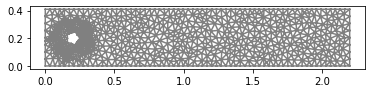

Reynolds number: 100 Viscosity: 0.001
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.008595034222863573


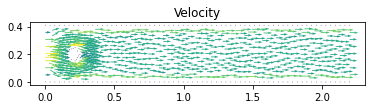

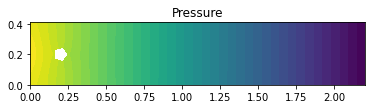

Time t = 1.005619004075037


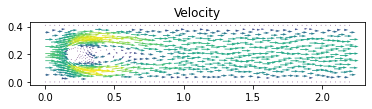

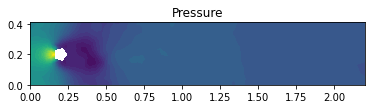

Time t = 2.0026429739272102


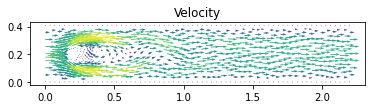

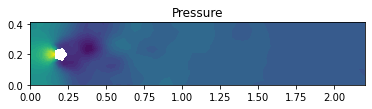

Time t = 3.008261978002273


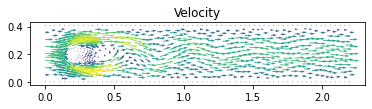

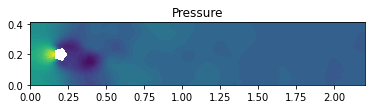

Time t = 4.005285947854472


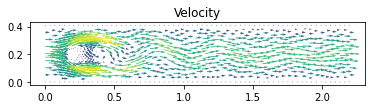

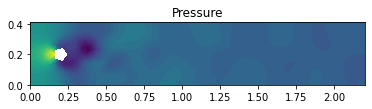

Time t = 5.0023099177066195


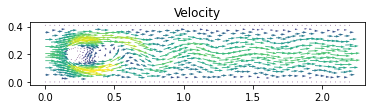

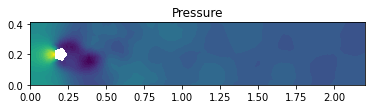

Time t = 6.00792892178163


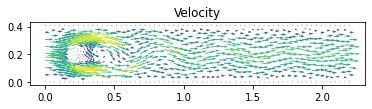

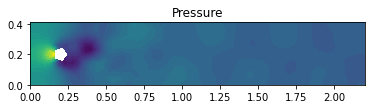

Time t = 7.004952891633778


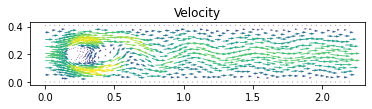

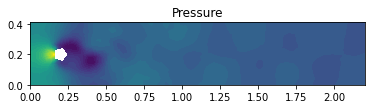

Time t = 8.001976861485925


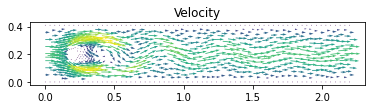

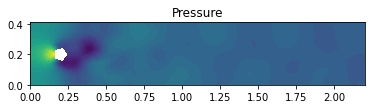

Time t = 9.00759586556104


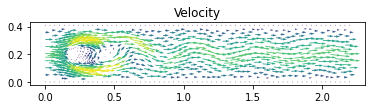

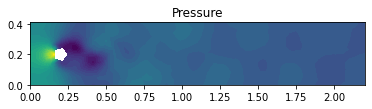

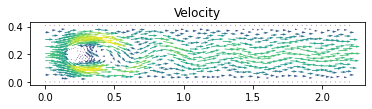

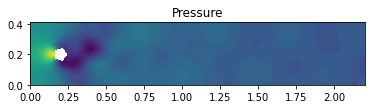

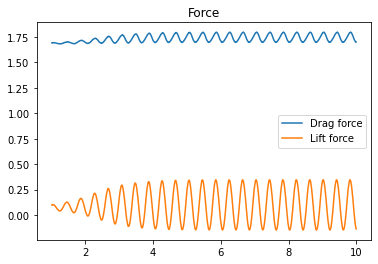

In [27]:
defDomain(plotting=True, spec=True, ref=1)
defApproxSpace()
defBC(spec=True)
defFlowParams(100)
defMethParams()
defVariProb()
forceExp()
defplot()
runSimulation(plotting=True, calcForces=True, T=10)
plotResult(vel=True, press=True, force=True)

#**Final remarks**
While the results where not completely as expected, they where nevertheless quite interesting. The high drag and lift coefficients might have been due to the nature of the simulation, however how this I am not sure about.

The benchmarking problem implementation seems to have been set up as prescribed
